### Импорты

In [370]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px

pd.options.mode.chained_assignment = None

### Задание 1

#### Подготовка источников

In [371]:
# Загрузка цен
df_prices_base = pd.read_excel('Тестовое_задание_Data_аналитик_ЦО_2025_.xlsx', sheet_name = 'Данные для задачи 1' )

# Переименование полей для удобства
df_prices_base.columns = ['brand', 'item_id', 'item_name', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'segment', 'purchase_price', 
        'letu', 'iledebeaute', 'rivegauche', 'ozon', 'wildberries', 'magnitmarket', 'megamarket', 'lamoda', 'tsum', 'visagehall' ]

In [372]:
# Загрузка справочника наценок
df_markups_base = pd.read_excel('Тестовое_задание_Data_аналитик_ЦО_2025_.xlsx', sheet_name = 'Справочник наценок' )

# Переименование полей для удобства и преобразование типов данных
df_markups_base.columns = ['segment', 'category', 'brand', 'item_id', 'start_d', 'end_d', 'markup', 'is_active' ]
df_markups_base['is_active'] = df_markups_base['is_active'].apply(lambda x: True if x == 'Да' else False ).astype('bool')
df_markups_base['end_d'] = df_markups_base['end_d'].apply(lambda x: datetime(2100, 1, 1) if pd.isna(x) else x )

#### Разработка справочников наценок

После изучение паттерна хранения данных в таблице справочника и логики использования (комбинации элементов), принял решение сформировать отдельные справочнике в формате словарей для бОльше прозрачности метрик и удобства работы с аналогичными задачами (чтобы избежать нечитамых/не поддающихся рефакторингу мёрджей и тд)

In [373]:
df_markups = df_markups_base.loc[df_markups_base.is_active & (df_markups_base.end_d > datetime.now() ) ]
df_markups.reset_index(drop = True, inplace = True)
df_markups.drop(columns = ['start_d', 'end_d', 'is_active'], inplace = True)

In [374]:
# Справочник товаров (items)
df_markups_items = (df_markups.loc[
                       df_markups.segment.isna()
                       & df_markups.category.isna()
                       & df_markups.brand.isna()
                       & ~df_markups.item_id.isna() ]
                       .drop(columns = ['segment','category', 'brand'])
                      )
df_markups_items['item_id'] = df_markups_items['item_id'].astype('int')
dict_markups_items = df_markups_items.set_index('item_id')['markup'].to_dict()

print(dict_markups_items)

{19000217070: 2.5, 19000419067: 2.5, 19000359936: 2.5, 14035900003: 2.0}


In [375]:
# Справочник брендов
df_markups_brands = (df_markups.loc[
                       df_markups.segment.isna()
                       & df_markups.category.isna()
                       & ~df_markups.brand.isna()
                       & df_markups.item_id.isna() ]
                       .drop(columns = ['segment','category','item_id'])
                      )
dict_markups_brand = df_markups_brands.set_index('brand')['markup'].to_dict()
dict_markups_brand

{'Clarins': 1.03, 'Vivienne Sabo': 0.59}

In [376]:
# Справочник сегментов
df_markups_segments = (df_markups.loc[
                       ~df_markups.segment.isna()
                       & df_markups.category.isna()
                       & df_markups.brand.isna()
                       & df_markups.item_id.isna() ]
                       .drop(columns = ['category', 'brand', 'item_id'])
                      )
dict_markups_segments = df_markups_segments.set_index('segment')['markup'].to_dict()
dict_markups_segments

{'Люкс': 1.2, 'Массмаркет': 0.7}

In [377]:
# Справочник бренд_категория
df_markups_brand_category = (df_markups.loc[
                                df_markups.segment.isna()
                                & ~df_markups.category.isna() 
                                & ~df_markups.brand.isna()
                                & df_markups.item_id.isna() ]
                       .drop(columns = ['segment', 'item_id'])
                      )
df_markups_brand_category['brand_category'] = df_markups_brand_category.apply(lambda x: (x.brand, x.category), axis = 1 )
dict_markups_brand_category = df_markups_brand_category[['brand_category', 'markup']].set_index('brand_category')['markup'].to_dict()

In [378]:
# Справочник сегмент_категория
df_markups_segments_category = (df_markups.loc[
                                ~df_markups.segment.isna()
                                & ~df_markups.category.isna()
                                & df_markups.brand.isna()
                                & df_markups.item_id.isna() ]
                       .drop(columns = ['brand', 'item_id'])
                      )
df_markups_segments_category['segment_category'] = df_markups_segments_category.apply(lambda x: (x.segment, x.category), axis = 1 )
dict_markups_segments_category = df_markups_segments_category[['segment_category', 'markup']].set_index('segment_category')['markup'].to_dict()

print(dict_markups_segments_category)

{('Люкс', 'Макияж'): 0.9, ('Люкс', 'Уход'): 1.5, ('Массмаркет', 'Макияж'): 0.5, ('Массмаркет', 'Уход'): 0.85, ('Массмаркет', 'Брови'): 1.1}


#### Обогащение наценками и отпускными ценами

In [379]:
# Функция, находящая наценку в справочниках в порядке и логике из задания

def markup_parse(item_id, brand, segment, cat_1, cat_2, cat_3, cat_4
                 , dict_markups_items = dict_markups_items
                 , dict_markups_brand = dict_markups_brand
                 , dict_markups_segments = dict_markups_segments
                 , dict_markups_brand_category = dict_markups_brand_category
                 , dict_markups_segments_category = dict_markups_segments_category ):
    markup = (
            dict_markups_items.get(item_id) 
            or dict_markups_brand_category.get((brand, cat_4) )
            or dict_markups_brand_category.get((brand, cat_3) )
            or dict_markups_brand_category.get((brand, cat_2) )
            or dict_markups_brand_category.get((brand, cat_1) )
            or dict_markups_brand.get(brand)
            or dict_markups_segments_category.get((segment, cat_4) )
            or dict_markups_segments_category.get((segment, cat_3) )
            or dict_markups_segments_category.get((segment, cat_2) )
            or dict_markups_segments_category.get((segment, cat_1) )
            or dict_markups_segments.get(segment)
             ) # Выдаёт первое не None значение в логической цепочке 
    
    return markup

In [380]:
df_prices = df_prices_base.copy()
df_prices[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = df_prices[['cat_1', 'cat_2', 'cat_3', 'cat_4']].replace({np.nan: None})
df_prices['markup'] = df_prices.apply(lambda x: markup_parse(x.item_id, x.brand, x.segment, x.cat_1, x.cat_2, x.cat_3, x.cat_4 ), axis = 1 )
df_prices['cat_total'] = df_prices.apply(lambda x: (x.cat_4 or x.cat_3 or x.cat_2 or x.cat_1 ), axis = 1 )
df_prices['ga_price'] = df_prices.apply(lambda x: x.purchase_price + x.purchase_price * x.markup, axis = 1 )

#### Расчёт синтетического К-значимости

Так как товар товару - рознь, а в датасете нет весовых категорий, создаю их синтетически по закупочным ценам с нормализацией по min-max значениям со смещением, чтобы минимальные значения не были нулевыми и околонулевыми

In [381]:
df_prices['min_purchase_price'] = df_prices['purchase_price'].min()
df_prices['max_purchase_price'] = df_prices['purchase_price'].max()
df_prices['k_value'] = df_prices.apply(lambda x: 0.1 + 0.9 * (x.purchase_price - x.min_purchase_price )/(x.max_purchase_price - x.min_purchase_price) , axis = 1 )

#### Unpivot датафрейма и очистка

Для расчётов данных в едином датафрейме едиными методами

In [382]:
competitors_lst = ['letu', 'iledebeaute', 'rivegauche', 'ozon', 'wildberries', 'magnitmarket', 'megamarket', 'lamoda', 'tsum', 'visagehall']

df_prices_unpivot = df_prices.melt(id_vars = ['brand', 'item_id', 'item_name', 'cat_total', 'segment', 'markup', 'k_value', 'purchase_price', 'ga_price'],
                  value_vars = competitors_lst,
                  var_name = 'comp_name',
                  value_name = 'comp_price' )

df_prices_unpivot = df_prices_unpivot.loc[~df_prices_unpivot.comp_price.isna() ]
df_prices_unpivot.reset_index(drop = True, inplace = True )

#### Расчёт текущих индексов цен по конкурентам

In [383]:
df_prices_index = (df_prices_unpivot.groupby(['comp_name'], as_index = False)
                   .apply(lambda x: pd.Series({
                        'price_index_w_k': (x.ga_price * x.k_value).sum() / (x.comp_price * x.k_value).sum(),
                        'price_index_wo_k': (x.ga_price / x.comp_price).mean() }) )
                   ).sort_values(by = ['price_index_w_k'], ascending = [False] )
df_prices_index

,comp_name,price_index_w_k,price_index_wo_k
9,wildberries,1.234249,1.302420
8,visagehall,1.220245,1.218346
6,rivegauche,1.208623,1.220707
5,ozon,1.188106,1.318997
3,magnitmarket,1.186663,1.219158
0,iledebeaute,1.182468,1.269944
1,lamoda,1.172605,1.219695
2,letu,1.143735,1.185649
4,megamarket,1.111789,1.199804
7,tsum,0.989322,0.999090


#### Экспресс-корректировка наценок

Экспресс-корректировка наценок с целью уменьшения индекса цен по каждой групп БРЕНД-СОВОКУПНАЯ КАТЕГОРИЯ до 0.95, чтобы быть ниже конкурентов по индексу

In [384]:
df_prices_new_markup = df_prices_unpivot.copy()

# Взвешенная цены ЗА и конкурентов по синтетичексому К-значимости
df_prices_new_markup['weighted_ga_price'] = df_prices_new_markup['ga_price'] * df_prices_new_markup['k_value']
df_prices_new_markup['weighted_ga_purchase_price'] = df_prices_new_markup['purchase_price'] * df_prices_new_markup['k_value']
df_prices_new_markup['weighted_ga_margin'] = df_prices_new_markup['weighted_ga_price'] - df_prices_new_markup['weighted_ga_purchase_price']

df_prices_new_markup['weighted_comp_price'] = df_prices_new_markup['comp_price'] * df_prices_new_markup['k_value']

# Совокупные взвешенные цены по БРЕНД-СОВОКУПНАЯ КАТЕГОРИЯ
df_prices_new_markup_agg = (df_prices_new_markup
                            .groupby(['brand','cat_total','comp_name'], as_index = False )
                            .agg(
                            weighted_ga_price = ('weighted_ga_price','sum' )
                            , weighted_ga_purchase_price = ('weighted_ga_purchase_price','sum' )
                            , weighted_ga_margin = ('weighted_ga_margin','sum' )
                            , weighted_comp_price = ('weighted_comp_price','sum' )
                            , current_markup = ('markup', lambda x: list(set(x))[0] ) )
                           )

# Максимальная новая наценка категории для целевого индекса (95%)
df_prices_new_markup_agg['max_new_markup'] = 0.95 * df_prices_new_markup_agg['weighted_comp_price'] / df_prices_new_markup_agg['weighted_ga_purchase_price'] - 1
df_prices_new_markup_agg['max_new_markup_cat'] = df_prices_new_markup_agg.groupby(['brand','cat_total'])['max_new_markup'].transform('min')
df_prices_new_markup_agg['max_new_markup_cat'] = df_prices_new_markup_agg['max_new_markup_cat'].apply(lambda x: round(x, 2) )

# Взвешенная цена при max_new_markup категории
df_prices_new_markup_agg['weighted_ga_price_cat_at_max'] = df_prices_new_markup_agg['weighted_ga_purchase_price'] * (1 + df_prices_new_markup_agg['max_new_markup_cat'])

# Маржа при max_markup категории
df_prices_new_markup_agg['max_weighted_margin_cat'] = df_prices_new_markup_agg['weighted_ga_price_cat_at_max'] - df_prices_new_markup_agg['weighted_ga_purchase_price']

# Процент маржи по взвешенным ценам с новыми наценками в категории
df_prices_new_markup_agg['max_margin_cat_p'] = df_prices_new_markup_agg['max_weighted_margin_cat'] / df_prices_new_markup_agg['weighted_ga_price_cat_at_max']

df_prices_new_markup_agg['price_index'] = df_prices_new_markup_agg['weighted_ga_price'] / df_prices_new_markup_agg['weighted_comp_price']
df_prices_new_markup_agg['price_index_new'] = df_prices_new_markup_agg['weighted_ga_price_cat_at_max'] / df_prices_new_markup_agg['weighted_comp_price']

df_prices_new_markup_agg['brand_category'] = df_prices_new_markup_agg.apply(lambda x: (x.brand, x.cat_total ), axis = 1 )

df_prices_new_markup_agg[['brand','cat_total', 'comp_name', 'weighted_ga_price_cat_at_max', 'weighted_ga_purchase_price', 'weighted_comp_price',
        'price_index', 'current_markup', 'max_new_markup', 'max_new_markup_cat', 'max_weighted_margin_cat', 'max_margin_cat_p', 'price_index_new']].head()

,brand,cat_total,comp_name,weighted_ga_price_cat_at_max,weighted_ga_purchase_price,weighted_comp_price,price_index,current_markup,max_new_markup,max_new_markup_cat,max_weighted_margin_cat,max_margin_cat_p,price_index_new
0,Clarins,Авто загар,iledebeaute,1953.852055,1285.428984,2180.492720,1.220292,1.07,0.611499,0.52,668.423071,0.342105,0.896060
1,Clarins,Авто загар,lamoda,1953.852055,1285.428984,2121.037129,1.254499,1.07,0.567559,0.52,668.423071,0.342105,0.921178
2,Clarins,Авто загар,ozon,1475.046004,970.425002,1615.152265,1.243709,1.07,0.581157,0.52,504.621001,0.342105,0.913255
3,Clarins,Авто загар,rivegauche,1953.852055,1285.428984,2060.503856,1.291353,1.07,0.522821,0.52,668.423071,0.342105,0.948240
4,Clarins,Авто загар,tsum,1953.852055,1285.428984,2609.570574,1.019646,1.07,0.928611,0.52,668.423071,0.342105,0.748726


#### Новый справочник бренд_категория

Намеренно допускаю вариант продажи некоторых категорий товаров в минус для сохранения статуса самых низких цен при общей достаточной маржинальности

In [385]:
dict_markups_brand_category_new = df_prices_new_markup_agg[['brand_category', 'max_new_markup_cat']].set_index('brand_category').to_dict()
dict_markups_brand_category_new

{'max_new_markup_cat': {('Clarins', 'Авто загар'): 0.52,
  ('Clarins', 'Адвент-календарь'): 0.61,
  ('Clarins', 'Антицеллюлитная серия/коррекция фигуры'): 0.57,
  ('Clarins', 'База под тушь'): 0.64,
  ('Clarins', 'Бальзам для губ_макияж'): 0.44,
  ('Clarins', 'Бальзам для лица'): 0.47,
  ('Clarins', 'Бальзамы для губ'): 0.53,
  ('Clarins', 'Блеск для губ'): 0.61,
  ('Clarins', 'Бронзер'): 0.6,
  ('Clarins', 'Бустеры'): 0.47,
  ('Clarins', 'ВВ/СС средства'): 0.52,
  ('Clarins', 'Гель для бритья'): 0.17,
  ('Clarins', 'Гель для бровей'): 0.55,
  ('Clarins', 'Гель для душа'): 0.5,
  ('Clarins', 'Гель для лица'): 0.55,
  ('Clarins', 'Гель для умывания'): 0.59,
  ('Clarins', 'Гель после бритья'): 0.27,
  ('Clarins', 'Гидрофильные средства'): 0.34,
  ('Clarins', 'Жидкая подводка'): 0.62,
  ('Clarins', 'Жидкие тональные основы'): 0.52,
  ('Clarins', 'Защита от 21 до 30 SPF'): 0.63,
  ('Clarins', 'Защита от 41 до 50 SPF'): 0.59,
  ('Clarins', 'Карандаш для бровей'): 0.55,
  ('Clarins', 'Каранд

In [386]:
# проверка новой общей маржи %
sum(df_prices_new_markup_agg.max_weighted_margin_cat) / sum(df_prices_new_markup_agg.weighted_ga_price_cat_at_max)

0.3394375694346971

#### Первый шаг для прод исследования

Для каждой связки бренд-категория рассчитал потенциал для снижения наценки; взвешенную по к-важности маржу, которая будет генерироваться после снижения наценки и "важность" категории по взвешенной закупочной цене (чем выше взвешенная закупочная цена, тем больше точка). Для предварительного анализа наценок/размеров категорий 

In [387]:
df_plot_cat = (
    df_prices_new_markup_agg
    .sort_values('max_new_markup_cat')
    .drop_duplicates(subset=['brand', 'cat_total'])
    .copy()
)

df_plot_cat['markup_gap_p'] = (df_plot_cat['current_markup'] - df_plot_cat['max_new_markup_cat']) * 100

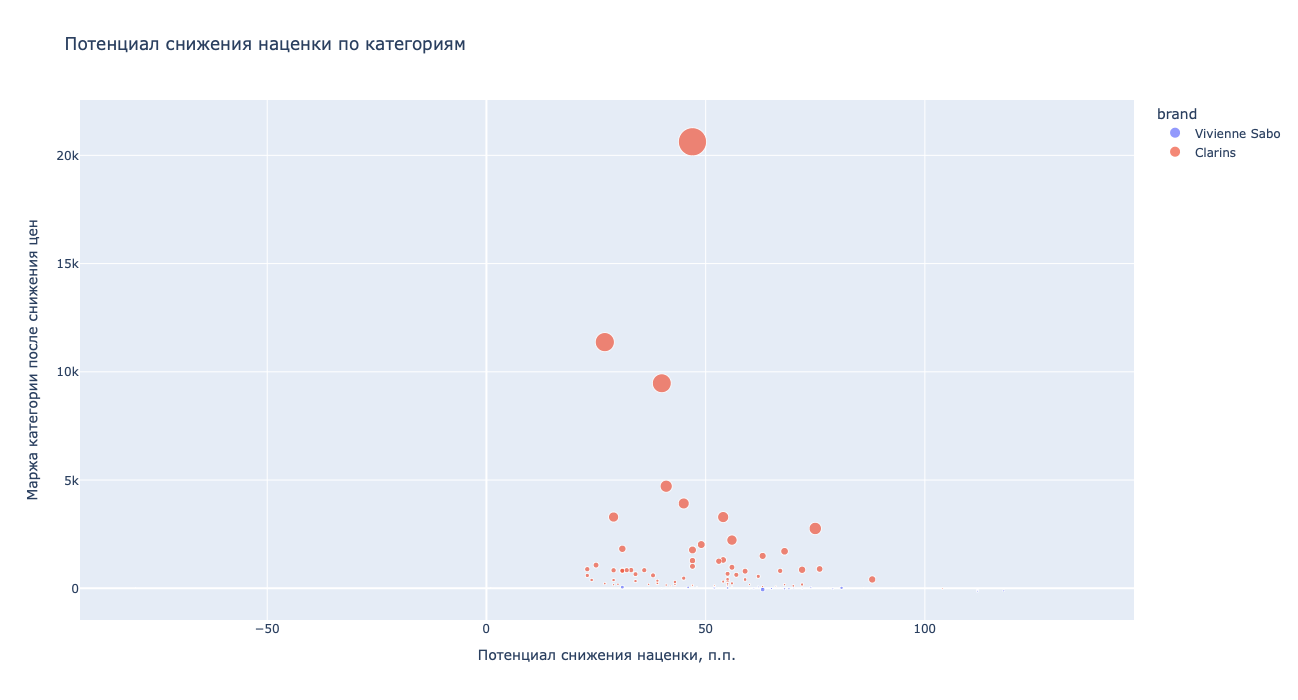

In [388]:
fig = px.scatter(
    df_plot_cat,
    x = 'markup_gap_p',
    y = 'max_weighted_margin_cat',
    size = 'weighted_ga_purchase_price',
    color = 'brand',
    hover_name = 'cat_total',
    hover_data = {
        'current_markup': ':.2f',
        'max_new_markup_cat': ':.2f',
        'price_index': ':.2f',
        'price_index_new': ':.2f',
        'max_margin_cat_p': ':.1%'
    },
    labels = {
        'markup_gap_p': 'Потенциал снижения наценки, п.п.',
        'max_weighted_margin_cat': 'Маржа категории после снижения цен'
    },
    title = 'Потенциал снижения наценки по категориям'
    , height = 700
)

fig.show()

#### plt график для визуализации в гите

Этот момент честно завайбкодил, в последний момент увидел, что Plotly не отражается в гите :) 

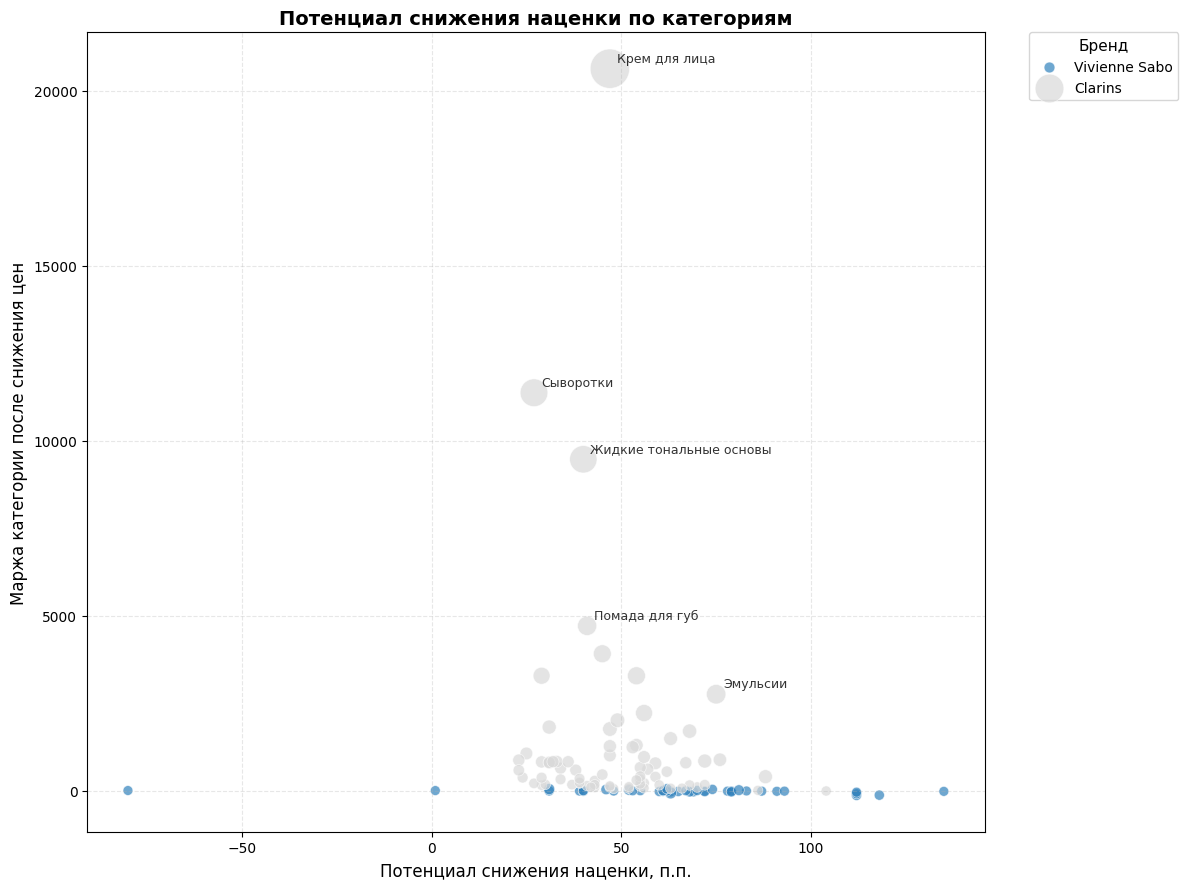

In [389]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 9))

# Уникальные бренды для цвета
unique_brands = df_plot_cat['brand'].unique()
colors = plt.cm.tab20c(np.linspace(0, 1, len(unique_brands)))
brand_to_color = {brand: color for brand, color in zip(unique_brands, colors)}

# Размер точек на основе weighted_ga_purchase_price
# Нормализуем размеры для лучшего отображения
sizes = df_plot_cat['weighted_ga_purchase_price']
min_size, max_size = 50, 800  # Минимальный и максимальный размер точек
sizes_normalized = min_size + (sizes - sizes.min()) / (sizes.max() - sizes.min()) * (max_size - min_size)

# Рисуем точки для каждого бренда
for brand in unique_brands:
    mask = df_plot_cat['brand'] == brand
    ax.scatter(
        df_plot_cat.loc[mask, 'markup_gap_p'],
        df_plot_cat.loc[mask, 'max_weighted_margin_cat'],
        s=sizes_normalized[mask],
        c=[brand_to_color[brand]],
        label=brand,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )

# Настройки графика
ax.set_xlabel('Потенциал снижения наценки, п.п.', fontsize=12)
ax.set_ylabel('Маржа категории после снижения цен', fontsize=12)
ax.set_title('Потенциал снижения наценки по категориям', fontsize=14, fontweight='bold')

# Сетка
ax.grid(True, alpha=0.3, linestyle='--')

# Легенда
legend = ax.legend(
    title='Бренд',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=10
)
legend.get_title().set_fontsize(11)

# Добавляем аннотации для самых крупных точек
# Берем топ-5 по размеру (весу)
top_indices = df_plot_cat.nlargest(5, 'weighted_ga_purchase_price').index
for idx in top_indices:
    row = df_plot_cat.loc[idx]
    ax.annotate(
        row['cat_total'],
        xy=(row['markup_gap_p'], row['max_weighted_margin_cat']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        alpha=0.8
    )

# Интерактивные подсказки (при наведении)
def hover(event):
    if event.inaxes == ax:
        # Находим ближайшую точку
        distances = np.sqrt(
            (df_plot_cat['markup_gap_p'] - event.xdata)**2 + 
            (df_plot_cat['max_weighted_margin_cat'] - event.ydata)**2
        )
        if distances.min() < 0.01:  # Порог близости
            idx = distances.idxmin()
            row = df_plot_cat.loc[idx]
            
            # Создаем текст подсказки
            tooltip_text = (
                f"Категория: {row['cat_total']}\n"
                f"Текущая наценка: {row['current_markup']:.2f}\n"
                f"Макс. новая наценка: {row['max_new_markup_cat']:.2f}\n"
                f"Индекс цен: {row['price_index']:.2f}\n"
                f"Новый индекс цен: {row['price_index_new']:.2f}\n"
                f"Макс. маржа: {row['max_margin_cat_p']:.1%}"
            )
            
            # Временная аннотация
            if hasattr(hover, 'ann'):
                hover.ann.remove()
            
            hover.ann = ax.annotate(
                tooltip_text,
                xy=(row['markup_gap_p'], row['max_weighted_margin_cat']),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.8),
                arrowprops=dict(arrowstyle="->"),
                fontsize=9
            )
            fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', hover)

plt.tight_layout()
plt.show()